In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from collections import defaultdict
from typing import DefaultDict, List, Hashable, Dict, Any

from src.pipeline.dataloader import DataLoader

import pandas as pd
import numpy as np

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.core import Reaction

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [4]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()
ENZYMES = protein_metabolite_df.to_df().columns.to_list()

PRECURSOR_METABOLITES = [
    'f6p', 'dhap',
    'pep', 'pyr', 'r5p', 'accoa', 'akg', 'oaa',
]

def get_gene_reaction():
    gene_to_reaction: DefaultDict[str, List[str]] = defaultdict(list)
    reaction_to_gene: DefaultDict[str, List[str]] = defaultdict(list)

    for gene in model.genes:
        if gene.id not in ENZYMES:
            continue

        for reaction in gene.reactions:
            gene_to_reaction[gene.id].append(reaction.id)
            reaction_to_gene[reaction.id].append(gene.id)
    return gene_to_reaction, reaction_to_gene

def is_precursor_metabolite(metabolite_model_id: str):
    for precursor_metabolite in PRECURSOR_METABOLITES:
        if precursor_metabolite in metabolite_model_id:
            yield precursor_metabolite

def get_matching_precursor_metabolite(cobra_metabolite_id):
    for precursor_metabolite in PRECURSOR_METABOLITES:
        if precursor_metabolite in cobra_metabolite_id:
            return precursor_metabolite

In [5]:
precursor_model_metabolites = list(filter(lambda x: any((pc_meta in x.id for pc_meta in PRECURSOR_METABOLITES)), model.metabolites))
precursor_model_metabolites_id = list(map(lambda x: x.id, precursor_model_metabolites))
print(f"{precursor_model_metabolites_id=}")

precursor_stiochiometric_df: pd.DataFrame = create_stoichiometric_matrix(model, array_type="DataFrame").loc[precursor_model_metabolites_id]
precursor_stiochiometric_df = precursor_stiochiometric_df.loc[:, (precursor_stiochiometric_df != 0).any(axis=0)]

print(f"{precursor_stiochiometric_df.index.to_list()=}")

gene_to_reaction, reaction_to_gene = get_gene_reaction()

precursor_reactions = list(map(lambda x: (reaction_to_gene[x], precursor_stiochiometric_df[x].values), precursor_stiochiometric_df.columns.to_list()))
precursor_reactions = [(enzyme, stiochiometrie) for enzymes, stiochiometrie in precursor_reactions for enzyme in enzymes]

edge_list_df = pd.DataFrame.from_records(precursor_reactions).T
edge_list_df = edge_list_df.explode(edge_list_df.columns.to_list()).set_axis(edge_list_df.iloc[0], axis=1)
edge_list_df = edge_list_df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(edge_list_df.columns, axis=1).sum()
edge_list_df = edge_list_df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
edge_list_df = edge_list_df[edge_list_df != 0].reset_index()
edge_list_df

precursor_model_metabolites_id=['2dr5p_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'apep_c', 'dhap_c', 'dhap_m', 'f6p_c', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pep_c', 'pep_m', 'pepd_c', 'pepd_e', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']
precursor_stiochiometric_df.index.to_list()=['2dr5p_c', '1pyr5c_c', '1pyr5c_m', '2cpr5p_c', 'akg_c', 'akg_e', 'akg_m', 'akg_n', 'akg_x', 'accoa_c', 'accoa_m', 'accoa_n', 'accoa_x', 'apep_c', 'dhap_c', 'dhap_m', 'f6p_c', 'indpyr_c', 'itaccoa_m', 'oaa_c', 'oaa_e', 'oaa_m', 'oaa_x', 'pep_c', 'pep_m', 'pepd_c', 'pepd_e', 'pyr_c', 'pyr_e', 'pyr_m', 'pyr_x', 'phpyr_c', 'r5p_c']


,metabolite_id,enzyme,cardinality
0,1pyr5c_c,YER023W,-1.0
1,akg_c,YDL171C,-1.0
2,akg_c,YGL202W,-1.0
3,akg_c,YIL116W,1.0
4,akg_c,YIR034C,1.0
...,...,...,...
103,r5p_c,YKL181W,-1.0
104,r5p_c,YMR105C,1.0
105,r5p_c,YOL061W,-1.0
106,r5p_c,YOR095C,-1.0


In [6]:
edge_list_df = pd.DataFrame.from_records(precursor_reactions).T
edge_list_df = edge_list_df.explode(edge_list_df.columns.to_list()).set_axis(edge_list_df.iloc[0], axis=1)
edge_list_df = edge_list_df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(edge_list_df.columns, axis=1).sum()
edge_list_df['metabolite_id'] = [get_matching_precursor_metabolite(cobra_metabolite_id) for cobra_metabolite_id in edge_list_df.index]
edge_list_df = edge_list_df.groupby('metabolite_id').sum()
edge_list_df = edge_list_df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
edge_list_df = edge_list_df[edge_list_df != 0].reset_index()
edge_list_df

,metabolite_id,enzyme,cardinality
0,accoa,YBL015W,-1.0
1,accoa,YBR026C,-1.0
2,accoa,YBR221C,1.0
3,accoa,YCR005C,-1.0
4,accoa,YDL040C,-1.0
...,...,...,...
88,r5p,YKL181W,-1.0
89,r5p,YMR105C,1.0
90,r5p,YOL061W,-1.0
91,r5p,YOR095C,-1.0


In [7]:
print(
    f"{edge_list_df['metabolite_id'].unique()=} \n"
    f"{len(edge_list_df['metabolite_id'].unique())=} \n"
)


edge_list_df['metabolite_id'].unique()=array(['accoa', 'akg', 'dhap', 'f6p', 'oaa', 'pep', 'pyr', 'r5p'],
      dtype=object) 
len(edge_list_df['metabolite_id'].unique())=8 



In [8]:
# precursor_reactions = list(map(lambda x: (reaction_to_gene[x], model.reactions.get_by_id(x).reversibility), precursor_stiochiometric_df.columns.to_list()))
# precursor_reactions = [(enzyme, stiochiometrie) for enzymes, stiochiometrie in precursor_reactions for enzyme in enzymes]

# df = pd.DataFrame.from_records(precursor_reactions).T
# df = df.set_axis(df.iloc[0], axis=1)
# df = df.drop(0).set_index(precursor_stiochiometric_df.index)
# df = df.drop(0).set_index(precursor_stiochiometric_df.index).groupby(df.columns, axis=1).sum()
# df = df.stack().rename_axis(['metabolite_id', 'enzyme']).rename("cardinality")
# df = df = df[df != 0].reset_index()
# df

In [9]:
matching_precursor_metabolite = [get_matching_precursor_metabolite(cobra_metabolite_id) for cobra_metabolite_id in edge_list_df['metabolite_id'].unique()]
matching_precursor_metabolite = [(metabolite_id, protein_metabolite_df.obs.loc[:, metabolite_id].values) for metabolite_id in matching_precursor_metabolite]
matching_precursor_metabolite = pd.DataFrame.from_records(matching_precursor_metabolite).T
matching_precursor_metabolite = matching_precursor_metabolite.explode(matching_precursor_metabolite.columns.to_list())
matching_precursor_metabolite.columns = edge_list_df['metabolite_id'].unique()
matching_precursor_metabolite = matching_precursor_metabolite.drop(0)
matching_precursor_metabolite.index = protein_metabolite_df.to_df().index
matching_precursor_metabolite


,accoa,akg,dhap,f6p,oaa,pep,pyr,r5p
KO_ORF,,,,,,,,
WT,4.820485,10.377185,1758.194055,5248.663203,1.202707,76.375142,2065.592332,143.661484
YAL017W,4.187382,11.189301,1295.57086,2843.905849,1.456754,45.407961,1686.43853,78.109384
YAR018C,4.654009,11.734239,1059.592474,2813.56018,1.597305,43.974617,1095.514167,80.395649
YBL016W,NaN,NaN,2116.528559,11798.792914,NaN,103.318199,3495.661987,206.846696
YBL088C,3.701013,10.349731,606.429346,2808.490162,1.112454,40.42441,1304.069277,42.801362
...,...,...,...,...,...,...,...,...
YPL150W,NaN,NaN,3798.871766,10265.84333,NaN,93.035312,3346.324255,307.585578
YPL203W,NaN,NaN,3736.339566,13007.621012,NaN,129.66151,4284.929796,355.770154
YPL236C,NaN,NaN,4044.817368,10471.008926,NaN,193.71365,4285.126919,294.746037


In [10]:
knockout_effect = pd.concat([
    protein_metabolite_df.to_df().loc[:, edge_list_df['enzyme'].unique()],
    matching_precursor_metabolite,
], axis=1).fillna(0)
knockout_effect

,YBL015W,YBR026C,YBR221C,YCR005C,YDL040C,YDL131W,YDL182W,YER178W,YFL017C,YFL018C,...,YOL061W,YOR095C,accoa,akg,dhap,f6p,oaa,pep,pyr,r5p
KO_ORF,,,,,,,,,,,,,,,,,,,,,
WT,4.174564,5.179256,6.638647,3.514944,4.519944,8.209560,7.899917,7.691228,4.877074,6.648276,...,4.228155,4.558896,4.820485,10.377185,1758.194055,5248.663203,1.202707,76.375142,2065.592332,143.661484
YAL017W,4.108255,5.039503,6.663648,4.105658,4.337737,8.122429,7.984877,7.399374,4.891090,6.179993,...,4.362003,4.659156,4.187382,11.189301,1295.570860,2843.905849,1.456754,45.407961,1686.438530,78.109384
YAR018C,4.006160,4.898486,7.226771,4.374624,4.207365,8.160167,7.975882,7.430188,4.880986,6.361118,...,4.173834,4.423617,4.654009,11.734239,1059.592474,2813.560180,1.597305,43.974617,1095.514167,80.395649
YBL016W,4.440667,5.596219,7.346413,5.036098,4.100035,8.231032,8.117892,7.619345,5.230466,6.047001,...,3.967907,6.121814,0.000000,0.000000,2116.528559,11798.792914,0.000000,103.318199,3495.661987,206.846696
YBL088C,3.962829,5.166425,6.774878,4.700088,3.209356,7.949945,7.736866,7.765750,4.841059,6.103474,...,3.481675,3.892507,3.701013,10.349731,606.429346,2808.490162,1.112454,40.424410,1304.069277,42.801362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,3.768529,5.060947,6.923290,3.662144,4.342356,8.360792,8.183218,7.547875,4.851903,6.346980,...,4.548423,4.753761,0.000000,0.000000,3798.871766,10265.843330,0.000000,93.035312,3346.324255,307.585578
YPL203W,4.328512,5.195951,6.944116,3.535606,4.230245,8.179124,7.973489,7.545774,4.999358,6.906320,...,4.318562,4.606985,0.000000,0.000000,3736.339566,13007.621012,0.000000,129.661510,4284.929796,355.770154
YPL236C,3.904583,4.997719,7.142187,4.230953,3.737662,8.131806,7.736179,7.729774,4.487868,6.535027,...,3.958174,4.706805,0.000000,0.000000,4044.817368,10471.008926,0.000000,193.713650,4285.126919,294.746037


#  Visualizations

In [11]:
len(edge_list_df['metabolite_id'].unique())

8

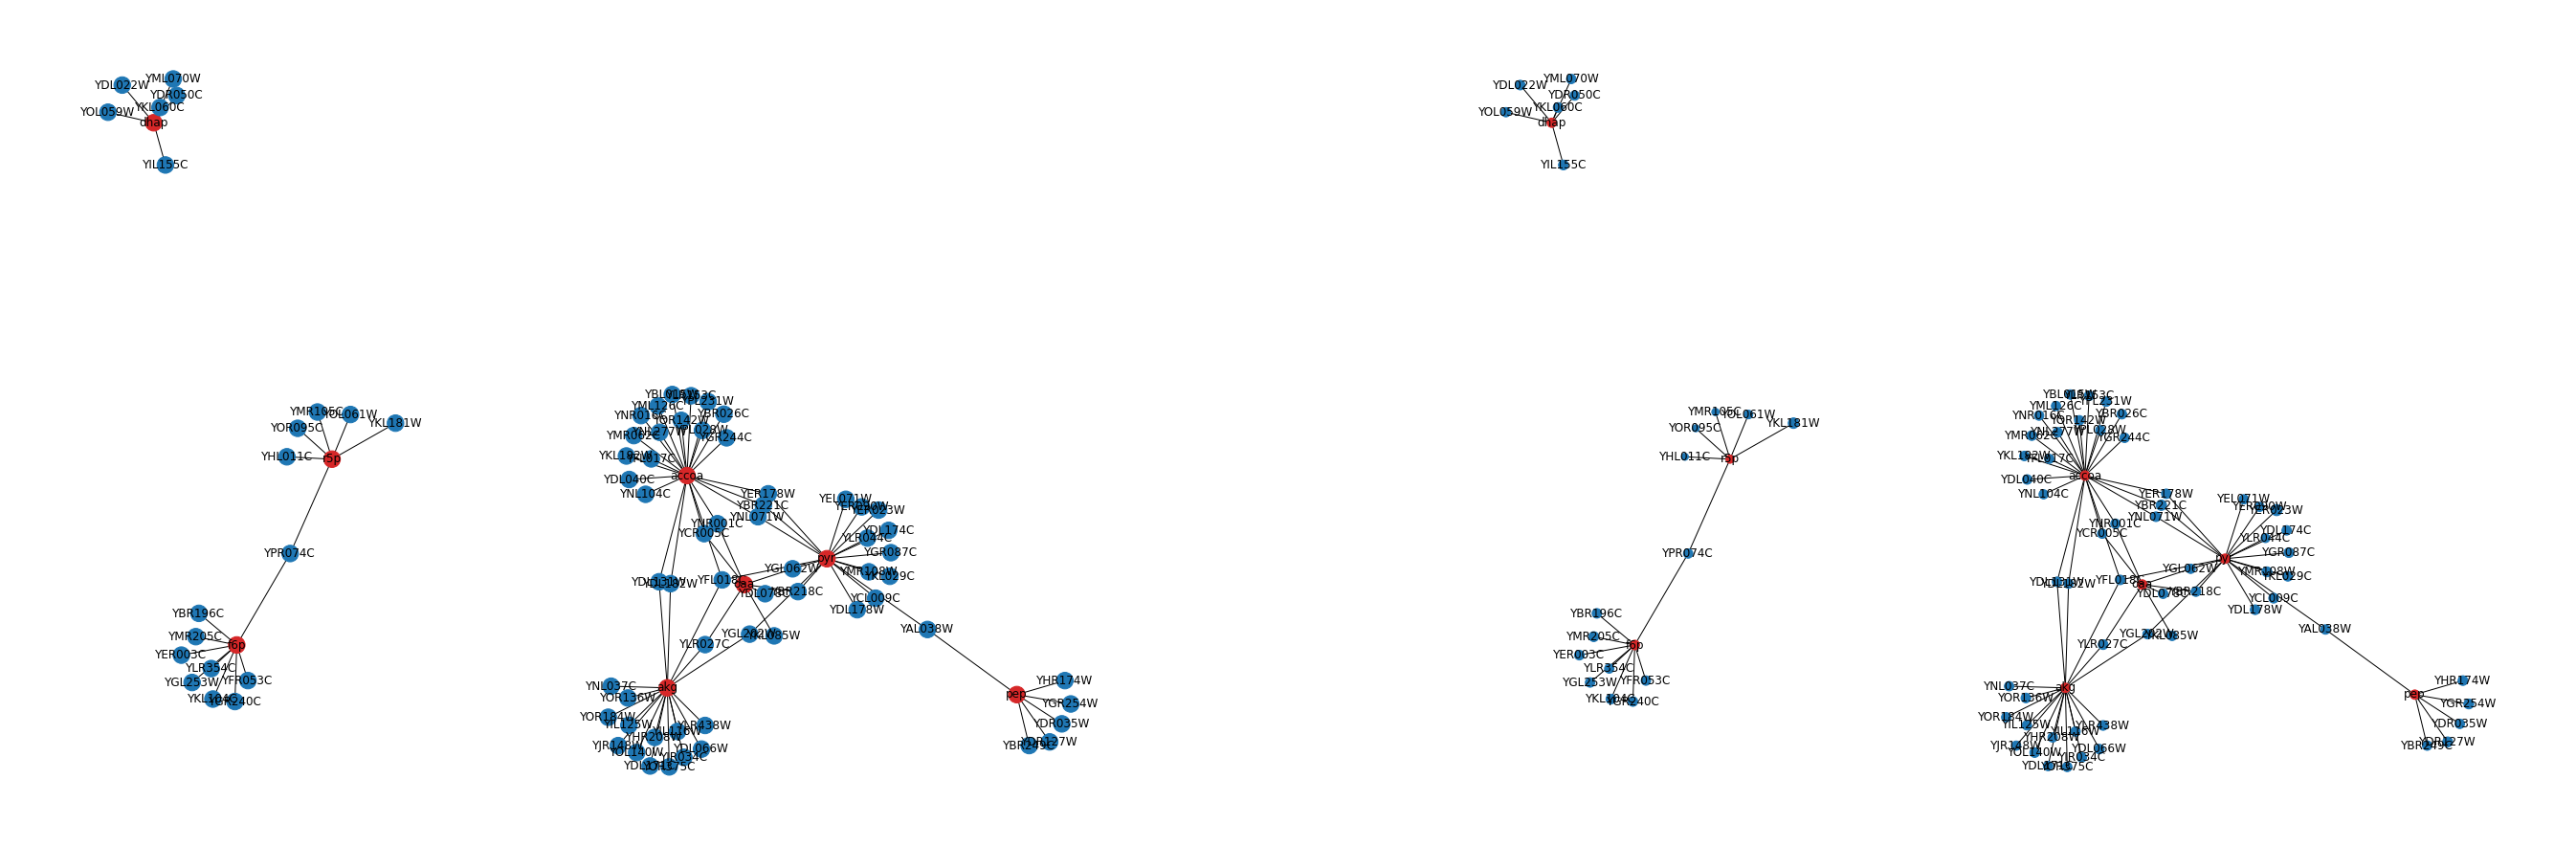

In [12]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 16))

pos = nx.fruchterman_reingold_layout(G)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    # node_size = knockout_effect.loc['WT'].values,
    ax=ax1
)

nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    node_size = (knockout_effect.loc['YAL017W'].values / knockout_effect.loc['WT'].values) * 100,
    ax=ax2
)

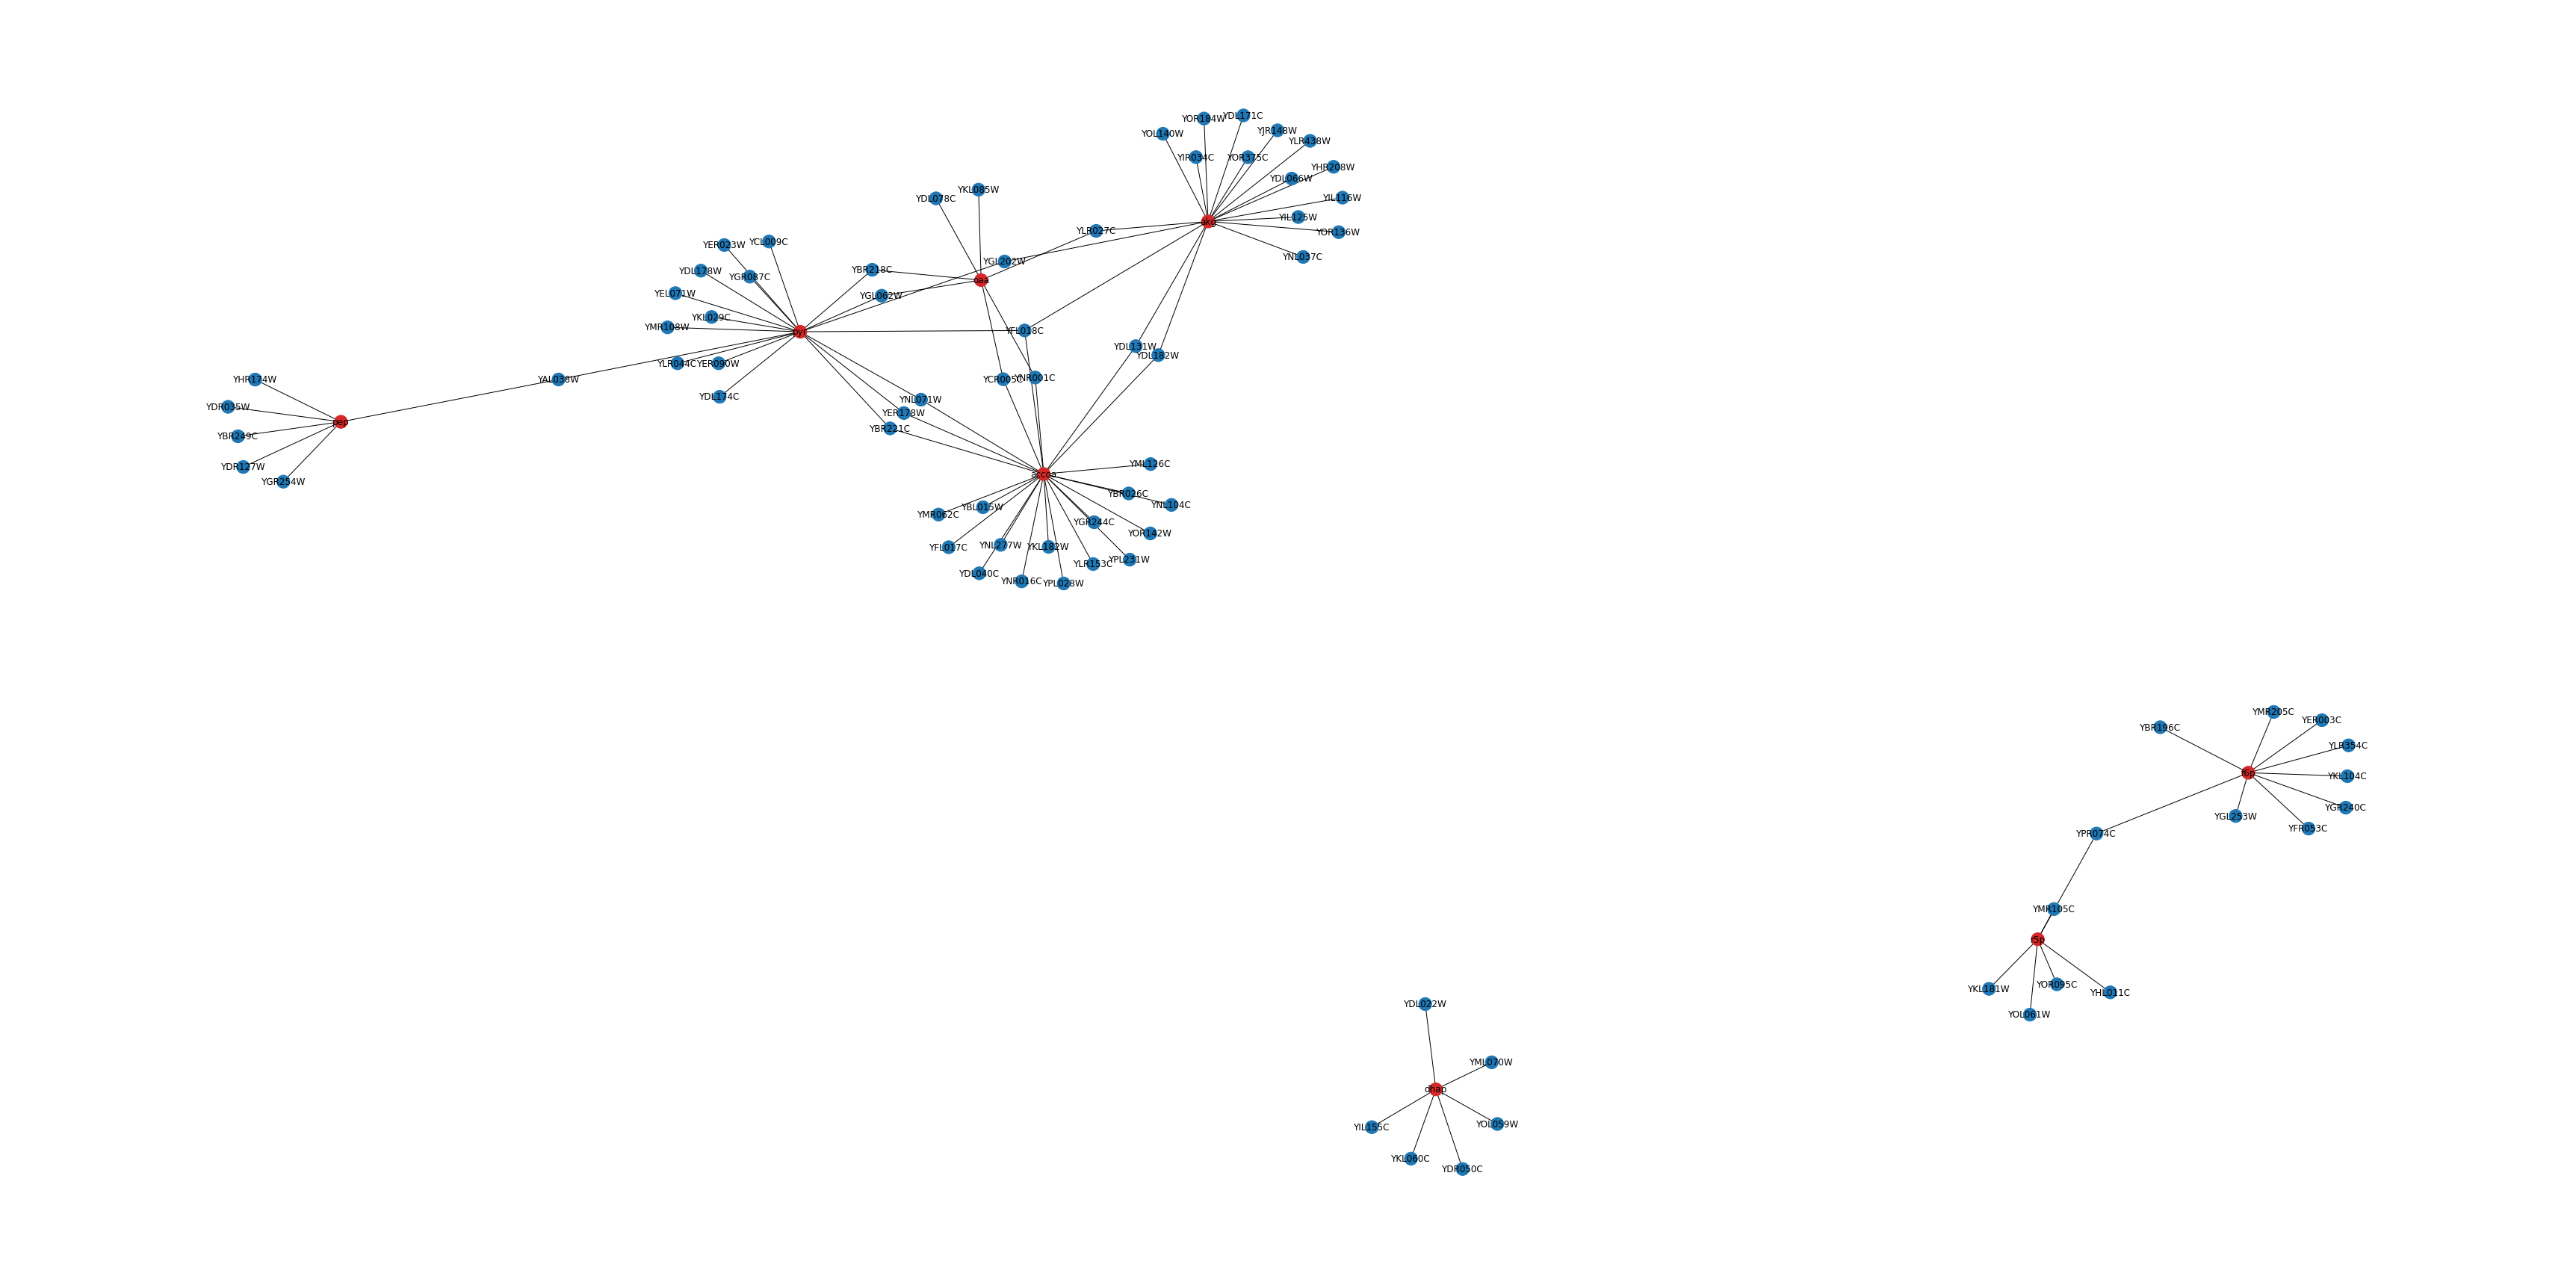

In [13]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in G]
node_size = np.random.randint(10, size=len(G)) * 100


fig, ax = plt.subplots(1, 1, figsize=(48, 24))

pos = nx.fruchterman_reingold_layout(G, k = 0.1)
nx.draw(
    G,
    pos = pos,
    with_labels = True,
    node_color = color_map,
    # node_size = knockout_effect.loc['WT'].values,
    ax=ax
)
plt.tight_layout()
plt.savefig("./images/explorative/wt_graph_metabolite_enzyme_interaction.png")
plt.savefig("./images/explorative/wt_graph_metabolite_enzyme_interaction.svg")

In [14]:
nx.is_connected(G)

False

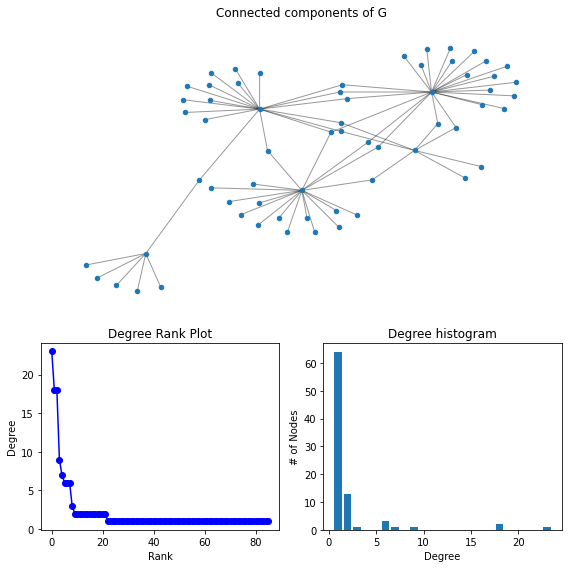

In [15]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

df = pd.DataFrame({
    "degree": np.unique(degree_sequence, return_counts=True)[0],
    "total": np.unique(degree_sequence, return_counts=True)[1],
    "metabolite": np.unique(degree_sequence, return_counts=True)[1],
    "enzyme": np.unique(degree_sequence, return_counts=True)[1],
})

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [16]:
np.unique(degree_sequence, return_counts=True)[1]

array([64, 13,  1,  3,  1,  1,  2,  1])

In [17]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

from src.utils.utils import get_generator, get_project_root
from src.utils.test_result_store import TestResultStore

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader, TaskFrame
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from scipy.stats import pearsonr

In [18]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'

tier = Tier.TIER0
strategy = Strategy.ALL

dl_config = DataLoaderConfig(
    additional_filters=["is_precursor", ],
    additional_transforms=["log_fold_change_protein", ]
)

tl_config = TaskLoaderConfig(
    data_throttle=1,
    tier=tier,
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(tl_config)

gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)
trainer = Trainer()

x_scaler = StandardScaler()
y_scaler = StandardScaler()

df_x = tf.x.reset_index(level="metabolite_id", drop=True).drop_duplicates()
df_y: pd.DataFrame = tf.y.to_frame().reset_index().pivot_table(values='metabolite_concentration', index='KO_ORF', columns='metabolite_id').loc[df_x.index]

scaled_x = x_scaler.fit_transform(df_x)
scaled_y = pd.DataFrame(y_scaler.fit_transform(df_y), columns=df_y.columns, index=df_y.index)

matching_precursor_metabolite = [
    (metabolite_id, scaled_y.loc[:, metabolite_id].values) 
    for cobra_metabolite_id in edge_list_df['metabolite_id'].unique()
    if (metabolite_id := list(filter(lambda p: p in cobra_metabolite_id, PRECURSOR_METABOLITES))[0])
]

cobra_df_y = pd.DataFrame.from_records(matching_precursor_metabolite).T
cobra_df_y = cobra_df_y.explode(cobra_df_y.columns.to_list()) \
    .drop(0) \
    .set_index(scaled_y.index) \
    .set_axis(edge_list_df['metabolite_id'].unique(), axis=1) \
    .fillna(0)
cobra_df_y

graph_fc_df = pd.concat([
    pd.DataFrame(scaled_x, index=df_x.index, columns=df_x.columns).loc[:, edge_list_df['enzyme'].unique()],
    cobra_df_y,
], axis=1).fillna(0)
graph_fc_df

,YBL015W,YBR026C,YBR221C,YCR005C,YDL040C,YDL131W,YDL182W,YER178W,YFL017C,YFL018C,...,YOL061W,YOR095C,accoa,akg,dhap,f6p,oaa,pep,pyr,r5p
KO_ORF,,,,,,,,,,,,,,,,,,,,,
YMR104C,-0.842481,-1.457042,0.153612,-1.096142,0.512107,-1.124559,-0.724562,-0.680206,-0.907828,-0.696708,...,-0.817672,0.957336,0.000000,0.000000,1.149227,0.388666,0.000000,0.878720,1.019120,1.086754
YDL214C,-0.548219,-0.836980,-0.712356,-0.419395,1.526607,0.590844,0.549457,0.520720,-0.133185,-0.574860,...,0.873860,1.017445,0.000000,0.000000,1.513568,0.493181,0.000000,-0.373125,0.417922,0.903701
YIL042C,-0.364112,0.568949,-0.187785,-0.809338,-0.989494,-1.250744,0.564957,-0.330401,0.647239,-0.325693,...,-0.323917,0.483516,0.594722,-1.040701,-1.443886,-1.813376,-1.187624,-1.975276,-2.151921,0.221629
YJL141C,0.126061,-0.640953,0.798811,-1.820141,1.315716,-0.395877,-1.054270,1.384029,0.971415,1.705409,...,-1.135968,-0.310197,0.000000,0.000000,0.640274,0.639662,0.000000,0.526304,0.667575,0.621483
YOL045W,-0.840666,0.029691,0.206895,-0.792074,-1.798900,0.410891,-0.747218,0.426163,-3.195559,-0.242317,...,0.214282,0.851333,0.000000,0.000000,0.801733,0.378117,0.000000,0.181257,0.863909,0.721533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YKL101W,-3.322590,2.071634,-0.610014,0.534653,0.158850,0.098493,0.623634,-0.385881,1.066794,0.350102,...,0.831035,-0.226314,0.000000,0.000000,0.503743,0.468028,0.000000,0.345743,0.492876,0.621513
YNL020C,-1.143804,0.041097,0.936460,-0.688854,0.319935,-1.949988,-0.785664,1.104407,1.198038,-0.616824,...,-2.431580,-1.609874,0.000000,0.000000,0.425537,0.407506,0.000000,0.677900,0.485339,0.266140
YKL126W,1.155117,1.276493,1.077125,1.744852,-0.019691,0.255080,-0.331244,0.938687,1.417384,0.197454,...,-1.664905,-2.172886,0.000000,0.000000,-0.483656,0.632867,0.000000,0.399854,0.529983,-0.168038


In [19]:
graph_fc_df.std()

YBL015W    1.005305
YBR026C    1.005305
YBR221C    1.005305
YCR005C    1.005305
YDL040C    1.005305
             ...   
f6p        1.005305
oaa        0.437595
pep        1.005305
pyr        1.005305
r5p        1.005305
Length: 86, dtype: float64

In [20]:
split_kwargs = dict(
    stratify='metabolite_id',
    shuffle=True
)
X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, Strategy.ALL, **split_kwargs)


In [21]:
h = np.array(X_test['KO_ORF'].unique())
k = np.array(X_test[X_test['metabolite_id'] == 'pyr']['KO_ORF'].unique())

np.argwhere(np.isin(h, k)).flatten().shape

(29,)

# Modeling

In [22]:
import os
from functools import partial

from tqdm import tqdm

import torch
from torch.nn import BatchNorm1d, ModuleList
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GAT, GCNConv, to_hetero, SAGEConv, GATConv, HeteroLinear, Linear, Node2Vec
import torch_geometric.transforms as T
from torch_geometric.nn.conv import HeteroConv

import mlflow.pytorch

from config import HYPERPARAMETERS, BEST_PARAMETERS

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.air import session, RunConfig
from ray.tune.integration.mlflow import mlflow_mixin
from ray.tune.integration.mlflow import MLflowLoggerCallback

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlflow.set_tracking_uri("http://localhost:5000")
device = torch.device("cpu")
torch.manual_seed(42)

/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [23]:
def data_augmentation_is_metabolite(node_name: str):
    return node_name not in ENZYMES

def data_augmentation_is_enzyme(node_name: str):
    return node_name in ENZYMES

def data_augmentation_train_mask(node_name: str, target_metabolite_id: str, concentration: float):
    return node_name not in ENZYMES and get_matching_precursor_metabolite(node_name) != target_metabolite_id and concentration != 0.0

def data_augmentation_test_mask(node_name: str, target_metabolite_id: str):
    return node_name not in ENZYMES and get_matching_precursor_metabolite(node_name) == target_metabolite_id

def data_augmentation_get_knockout_idx(knockout: str):
    return graph_fc_df.index.get_loc(knockout)

def data_augmentation_get_knockout_label(knockout_id: int):
    return graph_fc_df.iloc[[knockout_id]].index

def data_augmentation_get_pathway(node_name: str):
    # TODO: implement usefull encoding
    return np.random.randint(0, 2, size=1)[0]

In [24]:
G = nx.from_edgelist(
    zip(edge_list_df['metabolite_id'], edge_list_df['enzyme'])
)

def get_samples(target_metabolite_id: str):
    samples: List[Data] = []

    for idx, row_series in graph_fc_df.iterrows():
        # print(row_series.to_dict())
        attributes = {
            key: { 
                "fc": value, 
                "is_metabolite": data_augmentation_is_metabolite(key),
                "is_enzyme": data_augmentation_is_enzyme(key),
                "train_mask": data_augmentation_train_mask(key, target_metabolite_id),
                "test_mask": data_augmentation_test_mask(key, target_metabolite_id),
                "knockout_label_id": data_augmentation_get_knockout_idx(idx),
            } 
            for key, value in row_series.to_dict().items()
        }
        group_node_attr = list(attributes[list(attributes.keys())[0]].keys())
        
        nx.set_node_attributes(G, attributes)
        data: Data = from_networkx(G, group_node_attrs=group_node_attr)
        data.y = data.x[:, 0]
        data.train_mask = data.x[:, 3]
        data.test_mask = data.x[:, 4]
        data.knockout_id = data.x[:, 5]
        data.x = data.x[:, :3]
        samples.append(data)
        
    print(samples[0])
    return samples

# get_samples("pyr")

In [25]:
def from_node_attributes(attributes: Dict[Hashable, dict[str, Any]]):
    def collect_from_key(data, key: str):
        return [node[key] for id, node in data.items()]

    node_attributes = list(attributes[list(attributes.keys())[0]].keys())
    return torch.Tensor([collect_from_key(attributes, attribute) for attribute in node_attributes]).T.contiguous()

def edge_index_from_df(df : pd.DataFrame, edge_list: pd.DataFrame):
    first_row = df.iloc[[0]]
    enzyme_nodes = np.array([str(key) for key in first_row.to_dict().keys() if data_augmentation_is_enzyme(key)])
    metabolite_nodes = np.array([str(key) for key in first_row.to_dict().keys() if data_augmentation_is_metabolite(key)])

    edges = [
        [np.where(enzyme_nodes == enzyme)[0][0], np.where(metabolite_nodes == metabolite)[0][0]]
        for enzyme, metabolite in zip(edge_list['enzyme'], edge_list['metabolite_id'])
    ]

    return torch.Tensor(edges).to(torch.long).T

In [26]:
# edge_index = sample['regulates_reaction']['edge_index'].t().numpy().copy()
edge_index = edge_index_from_df(graph_fc_df, edge_list_df).T
edge_index[:, 1] = edge_index[:, 1] + edge_index[:, 0].max()

nodes = np.concatenate((np.unique(edge_index[:,0]), np.unique(edge_index[:,1])))
num_nodes = len(nodes)

np.random.shuffle(nodes) # shuffle node order

train_size = int(num_nodes*0.7)
test_size = int(num_nodes*0.85) - train_size
val_size = num_nodes - train_size - test_size

train_set = nodes[:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]

assert len(train_set) + len(test_set) + len(val_set) == len(nodes)

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

def get_mask(node_set, nodes):
    mask = torch.zeros(len(nodes), dtype=torch.long, device=device)
    for i in node_set:
        mask[np.argwhere(nodes == i)[0][0]] = 1.
    return mask

train_mask = get_mask(train_set, nodes)
test_mask = get_mask(test_set, nodes)
val_mask = get_mask(val_set, nodes)

print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15])

featureless_sample = Data(
    edge_index=edge_index.clone().detach().T,
    train_mask=train_mask,
    test_mask=test_mask,
    val_mask=val_mask,
)

model = Node2Vec(
    featureless_sample.edge_index,
    embedding_dim=32,
    walk_length=20,
    context_size=10,
    num_nodes=num_nodes,
)

loader = model.loader(batch_size=32, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(
            pos_rw.to(device), 
            neg_rw.to(device)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

node_embeddings = model()

train set	 [62 38 24 39 17 28  0 76 18 75]
test set 	 [63 23 72  5 34 44 58  7 51  9]
val set  	 [54 82 84 42 36 48 33 21 32 77]
train mask 	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Epoch: 10, Loss: 2.1754
Epoch: 20, Loss: 1.7403
Epoch: 30, Loss: 1.4219
Epoch: 40, Loss: 1.1282
Epoch: 50, Loss: 1.0143
Epoch: 60, Loss: 0.9291
Epoch: 70, Loss: 0.8670
Epoch: 80, Loss: 0.8468
Epoch: 90, Loss: 0.7930
Epoch: 100, Loss: 0.7738


In [27]:
def get_samples_hetero_graph(target_metabolite_id: str):
    samples: List[HeteroData] = []

    edge_index = edge_index_from_df(graph_fc_df, edge_list_df)

    for idx, row_series in graph_fc_df.iterrows():
        # print(row_series.to_dict())
        enzyme_attributes = {
            key: { 
                "fc": value, 
                # "knockout_label_id": data_augmentation_get_knockout_idx(idx),
            } 
            for key, value in row_series.to_dict().items()
            if data_augmentation_is_enzyme(key)
        }

        metabolite_attributes = {
            key: {
                "fc": value,
                "train_mask": data_augmentation_train_mask(key, target_metabolite_id, value),
                "test_mask": data_augmentation_test_mask(key, target_metabolite_id), 
                # "pathway": data_augmentation_get_pathway(key),
            } 
            for key, value in row_series.to_dict().items()
            if data_augmentation_is_metabolite(key)
        }

        # print(from_node_attributes(enzyme_attributes).shape)
        # print(from_node_attributes(metabolite_attributes).shape)

        enzyme_features = from_node_attributes(enzyme_attributes)
        metabolite_features = from_node_attributes(metabolite_attributes)

        num_metabolite_nodes = metabolite_features.shape[0]
        num_enzyme_nodes = enzyme_features.shape[0]

        data = HeteroData()
        data['enzymes'].x = torch.hstack((enzyme_features, node_embeddings[:num_enzyme_nodes]))
        data["enzymes"].num_nodes = num_enzyme_nodes

        data['metabolites'].x = torch.hstack((metabolite_features[:, 3:], node_embeddings[num_enzyme_nodes:]))
        data['metabolites'].y = metabolite_features[:, 0]
        data["metabolites"].train_mask = metabolite_features[:, 1]
        data["metabolites"].test_mask = metabolite_features[:, 2]
        data["metabolites"].num_nodes = num_metabolite_nodes

        data['enzymes', 'regulates_reaction', 'metabolites'].edge_index = edge_index

        data = T.ToUndirected()(data)
        # data = T.NormalizeFeatures()(data)

        samples.append(data)
    return samples

samples = get_samples_hetero_graph("pyr")
samples[0]

HeteroData(
  enzymes={
    x=[78, 33],
    num_nodes=78
  },
  metabolites={
    x=[8, 32],
    y=[8],
    train_mask=[8],
    test_mask=[8],
    num_nodes=8
  },
  (enzymes, regulates_reaction, metabolites)={ edge_index=[2, 93] },
  (metabolites, rev_regulates_reaction, enzymes)={ edge_index=[2, 93] }
)

In [28]:
def from_node_attributes(attributes: Dict[Hashable, dict[str, Any]]):
    def collect_from_key(data, key: str):
        return [node[key] for id, node in data.items()]

    node_attributes = list(attributes[list(attributes.keys())[0]].keys())
    return torch.Tensor([collect_from_key(attributes, attribute) for attribute in node_attributes]).T.contiguous()

def edge_index_from_df(df : pd.DataFrame, edge_list: pd.DataFrame):
    first_row = df.iloc[[0]]
    enzyme_nodes = np.array([str(key) for key in first_row.to_dict().keys() if data_augmentation_is_enzyme(key)])
    metabolite_nodes = np.array([str(key) for key in first_row.to_dict().keys() if data_augmentation_is_metabolite(key)])

    edges = [
        [np.where(enzyme_nodes == enzyme)[0][0], np.where(metabolite_nodes == metabolite)[0][0]]
        for enzyme, metabolite in zip(edge_list['enzyme'], edge_list['metabolite_id'])
    ]

    return torch.Tensor(edges).to(torch.long).T

def get_samples_hetero_graph_stacked_knockout(target_metabolite_id: str):
    edge_index = edge_index_from_df(graph_fc_df, edge_list_df)
    enzymes_features = []
    metabolite_features = []

    for key, value in graph_fc_df.to_dict().items():
        if data_augmentation_is_metabolite(key):
            pass
        elif data_augmentation_is_enzyme(key):
            pass

    for idx, row_series in graph_fc_df.iterrows():
        # print(row_series.to_dict())
        enzyme_attributes = {
            key: { 
                "fc": value, 
                # "knockout_label_id": data_augmentation_get_knockout_idx(idx),
            } 
            for key, value in row_series.to_dict().items()
            if data_augmentation_is_enzyme(key)
        }

        metabolite_attributes = {
            key: {
                "fc": value,
                "train_mask": data_augmentation_train_mask(key, target_metabolite_id, value),
                "test_mask": data_augmentation_test_mask(key, target_metabolite_id), 
                "pathway": data_augmentation_get_pathway(key),
            } 
            for key, value in row_series.to_dict().items()
            if data_augmentation_is_metabolite(key)
        }

        # print(from_node_attributes(enzyme_attributes).shape)
        # print(from_node_attributes(metabolite_attributes).shape)

        enzyme_feature = from_node_attributes(enzyme_attributes)
        metabolite_feature = from_node_attributes(metabolite_attributes)

        enzymes_features.append(enzyme_feature)
        metabolite_features.append(metabolite_feature)

    print(enzymes_features)
    print(torch.Tensor(enzymes_features).shape)

    data = HeteroData()
    data['metabolites'].x = metabolite_features[:, 3:]
    data['metabolites'].y = metabolite_features[:, 0]
    data["metabolites"].train_mask = metabolite_features[:, 1]
    data["metabolites"].test_mask = metabolite_features[:, 2]
    data["metabolites"].num_nodes = metabolite_features.shape[0]

    data['enzymes'].x = enzyme_features
    data["enzymes"].num_nodes = enzyme_features.shape[0]

    data['enzymes', 'regulates_reaction', 'metabolites'].edge_index  = edge_index

    data = T.ToUndirected()(data)
    # data = T.NormalizeFeatures()(data)

    return data

# samples = get_samples_hetero_graph_stacked_knockout("pyr")
# samples[0]

In [29]:
print(
    f"{samples[3]['metabolites'].train_mask} \n"
    f"{samples[3]['metabolites'].y} \n"
)

print(
    f"{samples[3]['metabolites'].test_mask} \n"
    f"{samples[3]['metabolites'].y}"
)

tensor([0., 0., 1., 1., 0., 1., 0., 1.]) 
tensor([0.0000, 0.0000, 0.6403, 0.6397, 0.0000, 0.5263, 0.6676, 0.6215]) 

tensor([0., 0., 0., 0., 0., 0., 1., 0.]) 
tensor([0.0000, 0.0000, 0.6403, 0.6397, 0.0000, 0.5263, 0.6676, 0.6215])


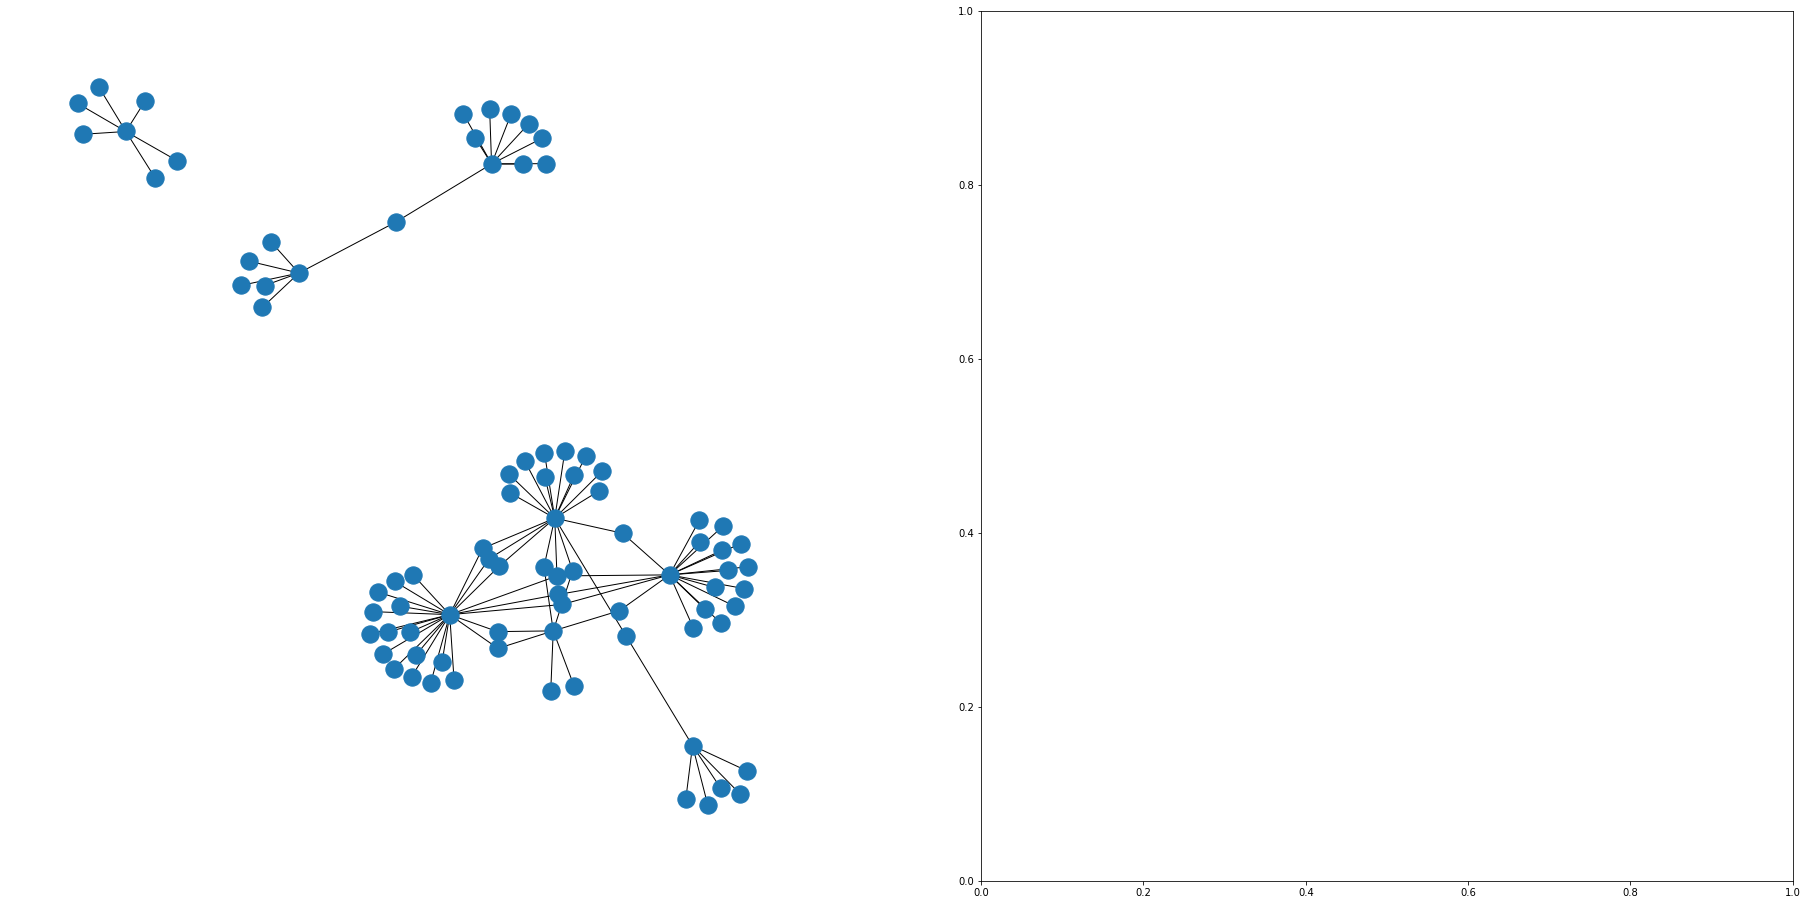

In [30]:
sample = samples[3]
t = sample['regulates_reaction']['edge_index'].T.numpy()
edges = np.stack([
    np.char.add(np.repeat("enzyme_", t.shape[0]), t[:, 0].astype(str)),
    np.char.add(np.repeat("metabolite_", t.shape[0]), t[:, 1].astype(str))
], axis=1)

G = nx.from_edgelist(edges)
pos = nx.fruchterman_reingold_layout(G, k = 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))
nx.draw(
    G,
    pos = pos,
    # with_labels = True,
    #     # node_color = color_map,
    # node_size = knockout_effect.loc['WT'].values,
    ax=ax1
)
# nx.degree_centrality(G)

## Model prep

In [31]:
def count_parameters(model):
    # for p in model.parameters():
    #     print(p)

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def log_metrics(all_preds, all_ground_truth, all_knockout_ids, epoch, type: str, debug=False):
    mae = mean_absolute_error(all_ground_truth, all_preds)
    r2 = pearsonr(all_preds, all_ground_truth)[0]
    # all_knockout_ids = [data_augmentation_get_knockout_label(knockout_id) for knockout_id in all_knockout_ids]
    
    # k = np.array(X_test[X_test['metabolite_id'] == 'pyr']['KO_ORF'].unique())
    # mask_idx = np.argwhere(np.isin(all_knockout_ids, k)).flatten()
    # masked_mae = mean_absolute_error(all_ground_truth[mask_idx], all_preds[mask_idx])
    # masked_r2 = pearsonr(all_preds[mask_idx], all_ground_truth[mask_idx])[0]
    
    if debug:
        print(f"{mae=}")
        print(f"{r2=}")
    mlflow.log_metric(key="Mean absolute error", value=float(mae), step=epoch)
    mlflow.log_metric(key="R2 score", value=float(r2), step=epoch)
    # mlflow.log_metric(key="Masked Mean absolute error", value=float(masked_mae), step=epoch)
    # mlflow.log_metric(key="Masked R2 score", value=float(masked_r2), step=epoch)



In [32]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(train_loader):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model.forward(
            batch.x_dict, 
            batch.edge_index_dict,
            # batch.edge_attr.float(),
            # batch.batch
        ) 
        # Calculating the loss and gradients
        train_mask = batch['metabolites'].train_mask.bool()
        loss = loss_fn(
            torch.squeeze(pred['metabolites']), 
            batch['metabolites'].y.float()
        )

        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
    
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save((model.state_dict(), optimizer.state_dict()), path)

    tune.report(loss=(running_loss/step))

    return running_loss/step
    
@mlflow_mixin
def test(epoch, model, test_loader, loss_fn, debug=False):
    all_preds_raw = []
    all_labels = []
    all_knockout_ids = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)
        # print(batch)  
        pred = model(
            batch.x_dict, 
            batch.edge_index_dict,
        )
        test_mask = batch['metabolites'].test_mask.bool()

        if debug:
            print(f"{test_mask.sum()=}")
            print(
                f"{pred['metabolites'].shape=} \n"
                f"{pred['metabolites'][test_mask].mean()=} \n"
                f"{pred['metabolites'][test_mask].max()=} \n"
                f"{pred['metabolites'][test_mask].min()=} \n"
                f"{pred['metabolites'][test_mask].shape=} \n"
            ) 
        
        loss = loss_fn(
            torch.squeeze(pred['metabolites'][test_mask]), 
            torch.squeeze(batch['metabolites'].y.float()[test_mask])
        )

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds_raw.append(pred['metabolites'][test_mask].cpu().detach().numpy())
        all_labels.append(batch['metabolites'].y[test_mask].cpu().detach().numpy())
        # all_knockout_ids.append(batch['enzymes'].knockout_label_id.cpu().detach().numpy())
    
    all_preds_raw = np.concatenate(all_preds_raw).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    # all_knockout_ids = np.concatenate(all_knockout_ids).ravel()
    log_metrics(all_preds_raw, all_labels, all_knockout_ids, epoch, "test")
    return running_loss/step

## Model construction

In [33]:
class GCNModel(torch.nn.Module):
    def __init__(self, feature_size, model_config) -> None:
        super(GCNModel, self).__init__()
        embedding_size = model_config["model_embedding_size"]
        n_heads = model_config["model_attention_heads"]
        self.n_layers = model_config["model_layers"]
        dropout_rate = model_config["model_dropout_rate"]
        top_k_ratio = model_config["model_top_k_ratio"]
        self.top_k_every_n = model_config["model_top_k_every_n"]
        dense_neurons = model_config["model_dense_neurons"]
        edge_dim = model_config["model_edge_dim"]
        
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        
        self.conv1 = GCNConv(
            feature_size, embedding_size
        )
        # self.transf1 = Linear(embedding_size, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)
        
        self.conv2 = GCNConv(
            embedding_size, embedding_size
        )
        
        self.linear1 = Linear(embedding_size, 1)
        self.linear2 = Linear(64, 1)
    
    def forward(self, x, edge_index, mask):
        # random weights for metabolite nodes should cancel out their contribution
        # metabolite_fc = torch.rand(x.shape[0], device=device)
        metabolite_fc = torch.zeros(x.shape[0], device=device)
        x[mask, 0] = metabolite_fc[mask]

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.8, training=self.training)
        
        # x = self.bn1(x)
        
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        
        x = self.linear1(x)
        # x = torch.relu(x)
        
        # x = self.linear2(x)
        return x 

class HeteroGCNModel(torch.nn.Module):
    def __init__(self, model_config) -> None:
        super(HeteroGCNModel, self).__init__()
        embedding_size = model_config["model_embedding_size"]
        n_heads = model_config["model_attention_heads"]
        self.n_layers = model_config["model_layers"]
        
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        
        self.conv1 = GATConv(
            (-1, -1), out_channels=embedding_size, heads=n_heads, add_self_loops=False, bias=False
        )
        self.transf1 = Linear(
            in_channels=embedding_size*n_heads, 
            out_channels=embedding_size, 
        )

        for i in range(self.n_layers):
            self.conv_layers.append(
                GATConv(
                    (-1, -1), 
                    out_channels=embedding_size, 
                    heads=n_heads, 
                    add_self_loops=False
                )
            )
            self.transf_layers.append(
                Linear(
                    embedding_size*n_heads, 
                    embedding_size
                )
            )

        self.conv2 = GATConv(
            (-1, -1), out_channels=1, add_self_loops=False, bias=False
        )

        self.linear1 = Linear(n_heads * embedding_size, embedding_size)
        self.linear2 = Linear(embedding_size, 1)
    
    def forward(self, x, edge_index):
        # random weights for metabolite nodes should cancel out their contribution
        # metabolite_fc = torch.rand(x.shape[0], device=device)
        
        x = self.conv1(x, edge_index)
        # print(x)
        # x = torch.relu(self.transf1(x))

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index)
            x = torch.relu(self.transf_layers[i](x))

        x = self.conv2(x, edge_index)
        
        # x = torch.relu(self.linear1(x))
        # x = F.dropout(x, p=0.8, training=self.training)
        # x = self.linear2(x)
        return x 

## Model running

In [34]:
model_config = {
    "model_embedding_size": 64,
    "model_attention_heads": 3,
    "model_layers": 5,
    "batch_size": 4,
    "learning_rate": 0.01,
    "sgd_momentum": 0.8,
    "scheduler_gamma": 1,
}

@mlflow_mixin
def run_one_training(model_config, metabolite_id, checkpoint_dir):
    print(f"creating model {model_config=}")
    samples = get_samples_hetero_graph(metabolite_id)
    params = model_config
    run_id = model_config['mlflow']['tags']['mlflow.parentRunId']
    with mlflow.start_run(nested=True) as run:
        mlflow.set_tag("mlflow.parentRunId", run_id)
        # Logging params
        for key in params.keys():
            mlflow.log_param(key, params[key])

        # Preparing training
        train_loader = GeoDataLoader(samples, batch_size=params['batch_size'])
        test_loader = GeoDataLoader(samples, batch_size=1)
        
        # Loading the model
        print("Loading model...")
        model = HeteroGCNModel(model_config=params)
        model = to_hetero(model, samples[0].metadata(), aggr='mean')
        model = model.to(device)

        if checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(checkpoint_dir, "checkpoint"))
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

        # < 1 increases precision, > 1 recall
        # loss_fn = torch.nn.MSELoss(reduction='none')
        loss_fn = torch.nn.MSELoss()
        # we need to keep the lr quite low since otherwise the weights explode
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=params['learning_rate'],
            momentum=params['sgd_momentum'],
            # weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['scheduler_gamma'])
        
        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        max_epochs = 1
        for epoch in tqdm(range(max_epochs)): 
            if early_stopping_counter <= 10: # = x * 5 
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                # print(f"Epoch {epoch} | Train Loss {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Testing
                model.eval()
                if epoch % 5 == 0 or epoch == max_epochs - 1:
                    loss = test(epoch, model, test_loader, loss_fn)
                    # print(f"Epoch {epoch} | Test Loss {loss}")
                    mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                    
                    # Update best loss
                    if float(loss) < best_loss:
                        best_loss = loss
                        # Save the currently best model 
                        # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                scheduler.step()
                mlflow.log_metric(key="Learning rate", value=float(scheduler.get_last_lr()[0]), step=epoch)
            else:
                print("Early stopping due to no improvement.")
                session.report({
                    "loss": best_loss
                })
                return {"loss": best_loss}
    print(f"Finishing training with best test loss: {best_loss}")

    with torch.no_grad():
        sample = samples[0].to(device)
        model.forward(sample.x_dict, sample.edge_index_dict)
        print(f"Number of parameters: {count_parameters(model)}")

    session.report({
        "loss": best_loss
    })
    return {"loss": best_loss}

In [49]:
@mlflow_mixin
def run_one_training(model_config, metabolite_id, checkpoint_dir):
    print(f"creating model {model_config=}")
    samples = get_samples_hetero_graph(metabolite_id)
    params = model_config
    # run_id = model_config['mlflow']['tags']['mlflow.parentRunId']

    # mlflow.set_tag("mlflow.parentRunId", run_id)
    # Logging params
    for key in params.keys():
        mlflow.log_param(key, params[key])

    # Preparing training
    train_loader = GeoDataLoader(samples, batch_size=params['batch_size'])
    test_loader = GeoDataLoader(samples, batch_size=1)
    
    # Loading the model
    print("Loading model...")
    model = HeteroGCNModel(model_config=params)
    model = to_hetero(model, samples[0].metadata(), aggr='mean')
    model = model.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # < 1 increases precision, > 1 recall
    # loss_fn = torch.nn.MSELoss(reduction='none')
    loss_fn = torch.nn.MSELoss()
    # we need to keep the lr quite low since otherwise the weights explode
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=params['learning_rate'],
        momentum=params['sgd_momentum'],
        # weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['scheduler_gamma'])
    
    # Start training
    best_loss = 1000
    early_stopping_counter = 0
    max_epochs = 10
    for epoch in tqdm(range(max_epochs)): 
        if early_stopping_counter <= 10: # = x * 5 
            # Training
            model.train()
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
            # print(f"Epoch {epoch} | Train Loss {loss}")
            mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

            # Testing
            model.eval()
            if epoch % 5 == 0 or epoch == max_epochs - 1:
                loss = test(epoch, model, test_loader, loss_fn)
                # print(f"Epoch {epoch} | Test Loss {loss}")
                mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                
                # Update best loss
                if float(loss) < best_loss:
                    best_loss = loss
                    # Save the currently best model 
                    # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

            scheduler.step()
            mlflow.log_metric(key="Learning rate", value=float(scheduler.get_last_lr()[0]), step=epoch)
        else:
            print("Early stopping due to no improvement.")
            session.report({
                "loss": best_loss
            })
            return {"loss": best_loss}
    print(f"Finishing training with best test loss: {best_loss}")

    with torch.no_grad():
        sample = samples[0].to(device)
        model.forward(sample.x_dict, sample.edge_index_dict)
        print(f"Number of parameters: {count_parameters(model)}")

    session.report({
        "loss": best_loss
    })
    return {"loss": best_loss}

In [36]:
HYPERPARAMETERS = {
    "batch_size": tune.choice([2, 4, 8]),
    "learning_rate": tune.choice([0.1, 0.05, 0.01, 0.001]),
    "sgd_momentum": tune.choice([0.9, 0.8, 0.5]),
    "scheduler_gamma": tune.choice([0.995, 0.9, 0.8, 0.5, 1]),
    "model_embedding_size": tune.choice([8, 16, 32, 64, 128]),
    "model_attention_heads": tune.choice([1, 2, 3, 4]),
    "model_layers": tune.choice([1, 3, 5, 7]),
}

In [ ]:
run_name = "model_gat_node_embeddings"
experiment_name = 'test'

def tune_metabolite_hyper_parameters(metabolite_id):
    mlflow.set_experiment(experiment_name=experiment_name)
    print(metabolite_id)
    print("Running hyperparameter search...")
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=1,
        reduction_factor=2
    )
    reporter = CLIReporter(
        metric_columns=["loss", "training_iteration"]
    )

    tuner = tune.Tuner(
        partial(run_one_training, metabolite_id=metabolite_id),
        tune_config=tune.TuneConfig(
            num_samples=10,
            # scheduler=scheduler,
            # progress_reporter=reporter,
        ),
        param_space={
            **HYPERPARAMETERS,
            "mlflow": {
                "experiment_name": experiment_name,
                "tracking_uri": mlflow.get_tracking_uri(),
                # "tags": {
                #     "mlflow.parentRunId": mlflow.active_run().info.run_id
                # }
            }
        },
        # run_config=RunConfig(
        #     name="mlflow",
        # ),
    )
    result = tuner.fit()

tune_metabolite_hyper_parameters("pyr")

In [51]:
run_name = "model_gat_node_embeddings"
experiment_name = 'test2'

def tune_metabolite_hyper_parameters(metabolite_id):
    mlflow.set_experiment(experiment_name=experiment_name)

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2
    )
    reporter = CLIReporter(
        metric_columns=["loss", "training_iteration"]
    )

    result = tune.run(
        partial(run_one_training, metabolite_id=metabolite_id),
        # resources_per_trial={"cpu": 1, "gpu": 1},
        config={
            **HYPERPARAMETERS,
            "mlflow": {
                "experiment_name": experiment_name,
                "tracking_uri": mlflow.get_tracking_uri(),
                # "tags": {
                #     "mlflow.parentRunId": mlflow.active_run().info.run_id
                # }
            }
        },
        num_samples=10,
        scheduler=scheduler,
        progress_reporter=reporter,
    )

tune_metabolite_hyper_parameters("pyr")

== Status ==
Current time: 2022-12-11 14:45:08 (running for 00:00:00.20)
Memory usage on this node: 4.3/23.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/11.67 GiB heap, 0.0/5.84 GiB objects
Result logdir: /home/tvangraft/ray_results/run_one_training_2022-12-11_14-45-08
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------------+----------+--------------------+--------------+-----------------+------------------------+------------------------+----------------+-------------------+----------------+
| Trial name                   | status   | loc                |   batch_size |   learning_rate |   model_attention_head |   model_embedding_size |   model_layers |   scheduler_gamma |   sgd_momentum |
|                              |          |                    |              |            

  0%|          | 0/10 [00:00<?, ?it/s]


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
run_one_training_0693e_00000,2022-12-11_14-45-17,True,,7b10e06ef9ec4c9aa2ed2197b29be2ff,"0_batch_size=8,learning_rate=0.0100,model_attention_heads=3,model_embedding_size=16,model_layers=7,scheduler_gamma=0.9000,sgd_momentum=0.9000",VGI-DEKSPTOP-TIJMEn,12,1.00003,172.29.86.26,18950,6.97239,0.00408864,6.97239,1670766317,0,,12,0693e_00000,0.00221467
run_one_training_0693e_00001,2022-12-11_14-45-21,True,,15ece664c4ae408884a3d899e528ef61,"1_batch_size=8,learning_rate=0.0100,model_attention_heads=4,model_embedding_size=64,model_layers=5,scheduler_gamma=0.8000,sgd_momentum=0.5000",VGI-DEKSPTOP-TIJMEn,12,1.00001,172.29.86.26,18978,7.80424,0.00246954,7.80424,1670766321,0,,12,0693e_00001,0.00262642
run_one_training_0693e_00002,2022-12-11_14-45-14,True,,e658939cc50f4e94abf41f5357c4f0a6,,VGI-DEKSPTOP-TIJMEn,1,0.719058,172.29.86.26,18980,0.80836,0.80836,0.80836,1670766314,0,,1,0693e_00002,0.00272202
run_one_training_0693e_00003,2022-12-11_14-45-15,True,,481730d43ef14b588405192114fe1f78,,VGI-DEKSPTOP-TIJMEn,2,0.702566,172.29.86.26,18982,1.72178,1.04578,1.72178,1670766315,0,,2,0693e_00003,0.00258803
run_one_training_0693e_00004,2022-12-11_14-45-14,True,,43348fd755e64836bce7381b8dd1132a,,VGI-DEKSPTOP-TIJMEn,1,0.71732,172.29.86.26,18984,0.898116,0.898116,0.898116,1670766314,0,,1,0693e_00004,0.0025816
run_one_training_0693e_00005,2022-12-11_14-45-18,True,,6d789a8a8dd84a0bb8b5e7d48d787c53,"5_batch_size=8,learning_rate=0.0100,model_attention_heads=1,model_embedding_size=8,model_layers=7,scheduler_gamma=0.9000,sgd_momentum=0.8000",VGI-DEKSPTOP-TIJMEn,12,1.00001,172.29.86.26,18986,5.16956,0.00267386,5.16956,1670766318,0,,12,0693e_00005,0.00263
run_one_training_0693e_00006,2022-12-11_14-45-19,True,,1f4c11e7788743009957f6acc02cc966,"6_batch_size=8,learning_rate=0.0010,model_attention_heads=1,model_embedding_size=32,model_layers=7,scheduler_gamma=0.9950,sgd_momentum=0.8000",VGI-DEKSPTOP-TIJMEn,12,1.00006,172.29.86.26,18988,5.46541,0.00289869,5.46541,1670766319,0,,12,0693e_00006,0.00241351
run_one_training_0693e_00007,2022-12-11_14-45-14,True,,3186b67aca9a4dc5a439812380d065d9,,VGI-DEKSPTOP-TIJMEn,1,0.708039,172.29.86.26,18990,0.668815,0.668815,0.668815,1670766314,0,,1,0693e_00007,0.00267005
run_one_training_0693e_00008,2022-12-11_14-45-14,True,,aa69040b71fe4ebebc61ce738346c12c,,VGI-DEKSPTOP-TIJMEn,1,0.704214,172.29.86.26,18992,1.13853,1.13853,1.13853,1670766314,0,,1,0693e_00008,0.00219989
run_one_training_0693e_00009,2022-12-11_14-45-16,True,,c61c55a5a39a491e8e3a94852f3815be,,VGI-DEKSPTOP-TIJMEn,4,0.697851,172.29.86.26,18994,3.22918,0.439089,3.22918,1670766316,0,,4,0693e_00009,0.00237465


 30%|███       | 3/10 [00:02<00:04,  1.54it/s]


(func pid=18984) creating model model_config={'batch_size': 4, 'learning_rate': 0.05, 'sgd_momentum': 0.8, 'scheduler_gamma': 0.8, 'model_embedding_size': 8, 'model_attention_heads': 1, 'model_layers': 5, 'mlflow': {'experiment_name': 'test2', 'tracking_uri': 'http://localhost:5000'}}
(func pid=18980) creating model model_config={'batch_size': 4, 'learning_rate': 0.01, 'sgd_momentum': 0.9, 'scheduler_gamma': 0.8, 'model_embedding_size': 32, 'model_attention_heads': 1, 'model_layers': 5, 'mlflow': {'experiment_name': 'test2', 'tracking_uri': 'http://localhost:5000'}}
(func pid=18982) creating model model_config={'batch_size': 8, 'learning_rate': 0.05, 'sgd_momentum': 0.5, 'scheduler_gamma': 0.9, 'model_embedding_size': 16, 'model_attention_heads': 3, 'model_layers': 5, 'mlflow': {'experiment_name': 'test2', 'tracking_uri': 'http://localhost:5000'}}
== Status ==
Current time: 2022-12-11 14:45:13 (running for 00:00:05.23)
Memory usage on this node: 6.7/23.5 GiB 
Using AsyncHyperBand: num_

 40%|████      | 4/10 [00:02<00:03,  1.53it/s]


(func pid=18980) Loading model...
(func pid=18978) Loading model...
(func pid=18988) Loading model...
(func pid=18986) Loading model...
(func pid=18982) Loading model...
(func pid=18990) Loading model...
(func pid=18994) Loading model...
(func pid=18992) Loading model...
(func pid=18984) Loading model...


 40%|████      | 4/10 [00:03<00:04,  1.42it/s]


(func pid=18950) Finishing training with best test loss: 1.000027646096791
(func pid=18950) Number of parameters: 48725


 90%|█████████ | 9/10 [00:04<00:00,  2.83it/s]


== Status ==
Current time: 2022-12-11 14:45:18 (running for 00:00:10.59)
Memory usage on this node: 5.2/23.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.6968275929490725 | Iter 4.000: -0.6972359269857407 | Iter 2.000: -0.6980338456730049 | Iter 1.000: -0.7036450694625576
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/11.67 GiB heap, 0.0/5.84 GiB objects
Result logdir: /home/tvangraft/ray_results/run_one_training_2022-12-11_14-45-08
Number of trials: 10/10 (3 RUNNING, 7 TERMINATED)
+------------------------------+------------+--------------------+--------------+-----------------+------------------------+------------------------+----------------+-------------------+----------------+----------+----------------------+
| Trial name                   | status     | loc                |   batch_size |   learning_rate |   model_attention_head |   model_embedding_size |   model_layers |   scheduler_gamma |   sgd_m

 60%|██████    | 6/10 [00:05<00:03,  1.22it/s]


(func pid=18988) Finishing training with best test loss: 1.0000555094464767
(func pid=18988) Number of parameters: 51365


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
2022-12-11 14:45:21,631	INFO tune.py:777 -- Total run time: 13.37 seconds (13.24 seconds for the tuning loop).


== Status ==
Current time: 2022-12-11 14:45:21 (running for 00:00:13.25)
Memory usage on this node: 4.4/23.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.6966128970185915 | Iter 4.000: -0.6972359269857407 | Iter 2.000: -0.6980338456730049 | Iter 1.000: -0.7036450694625576
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/11.67 GiB heap, 0.0/5.84 GiB objects
Result logdir: /home/tvangraft/ray_results/run_one_training_2022-12-11_14-45-08
Number of trials: 10/10 (10 TERMINATED)
+------------------------------+------------+--------------------+--------------+-----------------+------------------------+------------------------+----------------+-------------------+----------------+----------+----------------------+
| Trial name                   | status     | loc                |   batch_size |   learning_rate |   model_attention_head |   model_embedding_size |   model_layers |   scheduler_gamma |   sgd_momentum |   

In [53]:
run_name = "model_gat_node_embeddings"
experiment_name = 'metabolite_gnn_sweep'
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name=run_name) as run:
    for metabolite_id in PRECURSOR_METABOLITES:
        with mlflow.start_run(run_name=f"model_{metabolite_id}", nested=True):
            print(metabolite_id)
            print("Running hyperparameter search...")
            scheduler = ASHAScheduler(
                metric="loss",
                mode="min",
                max_t=100,
                grace_period=1,
                reduction_factor=2
            )
            reporter = CLIReporter(
                metric_columns=["loss", "training_iteration"]
            )

            tuner = tune.Tuner(
                partial(run_one_training, metabolite_id=metabolite_id),
                tune_config=tune.TuneConfig(
                    num_samples=10,
                    scheduler=scheduler,
                    # progress_reporter=reporter,
                ),
                param_space={
                    **HYPERPARAMETERS,
                    "mlflow": {
                        "experiment_name": "some_experiment",
                        "tracking_uri": mlflow.get_tracking_uri(),
                        # "tags": {
                        #     "mlflow.parentRunId": mlflow.active_run().info.run_id
                        # }
                    }
                },
                run_config=RunConfig(
                    name="mlflow",
                ),
            )
            result = tuner.fit()

            # result = tune.run(
            #     partial(run_one_training, metabolite_id=metabolite_id),
            #     # resources_per_trial={"cpu": 1, "gpu": 1},
            #     config={
            #         **HYPERPARAMETERS,
            #         "experiment_name": experiment_name,
            #         "tracking_uri": mlflow.get_tracking_uri(),
            #         "tags": {
            #             "mlflow.parentRunId": mlflow.active_run().info.run_id
            #         }
            #     },
            #     num_samples=10,
            #     scheduler=scheduler,
            #     progress_reporter=reporter,
            #     run_config=RunConfig(
            #         name="mlflow",
            #     ),
            #     # callbacks=[
            #     #     MLflowLoggerCallback(
            #     #         experiment_name=experiment_name,
            #     #         save_artifact=True,
            #     #         tags={
            #     #             "mlflow.parentRunId": mlflow.active_run().info.run_id
            #     #         }
            #     #     )
            #     # ]
            # )
            print(result)


        # run_one_training(metabolite_id)

Exception: Run with UUID fdd630047546417589034278e97ac047 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True